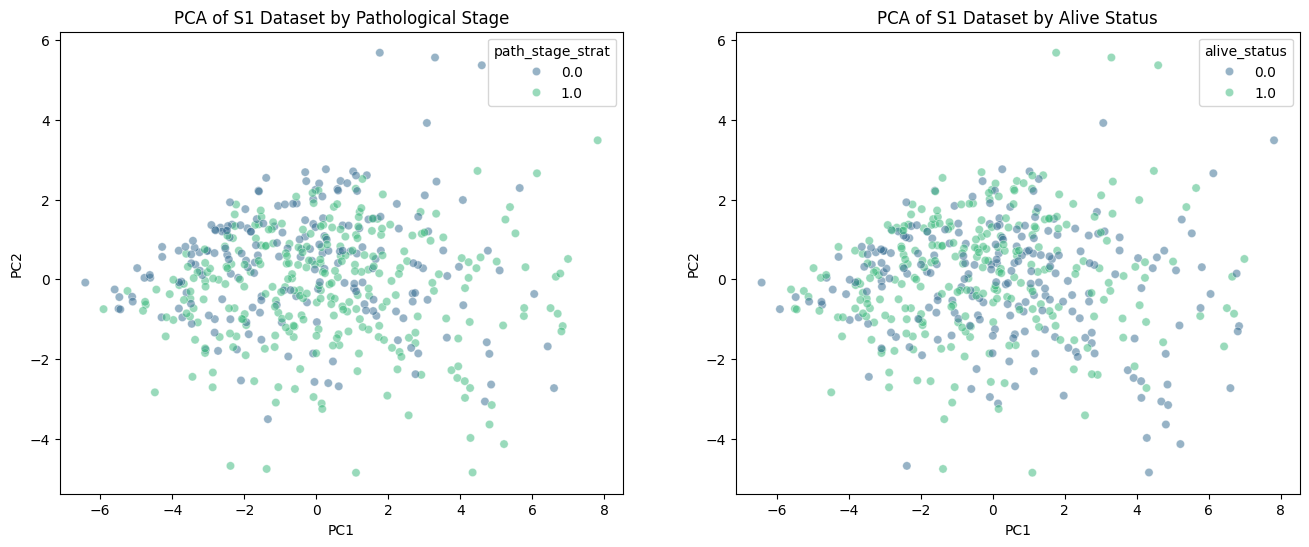

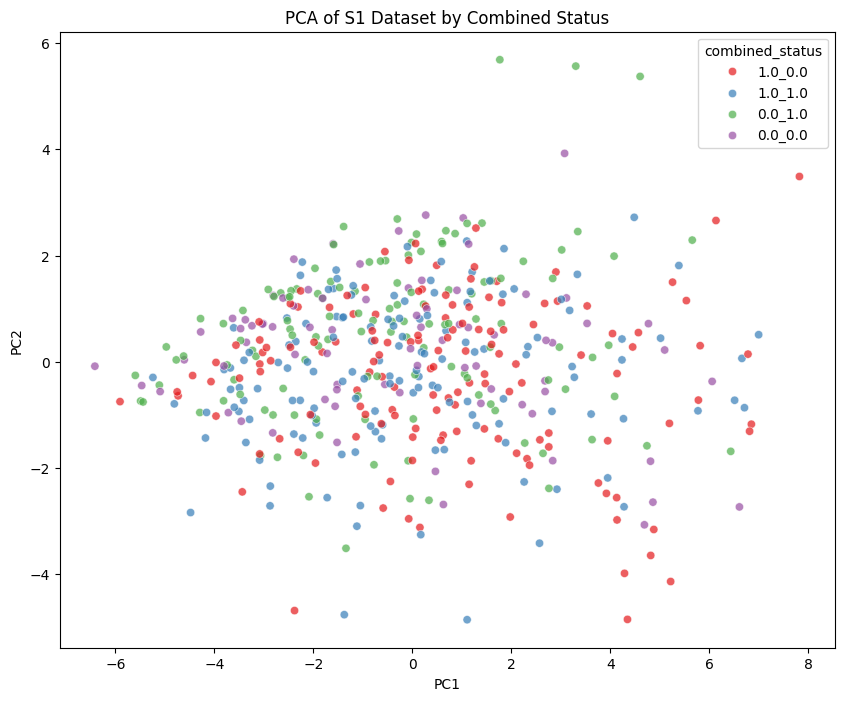

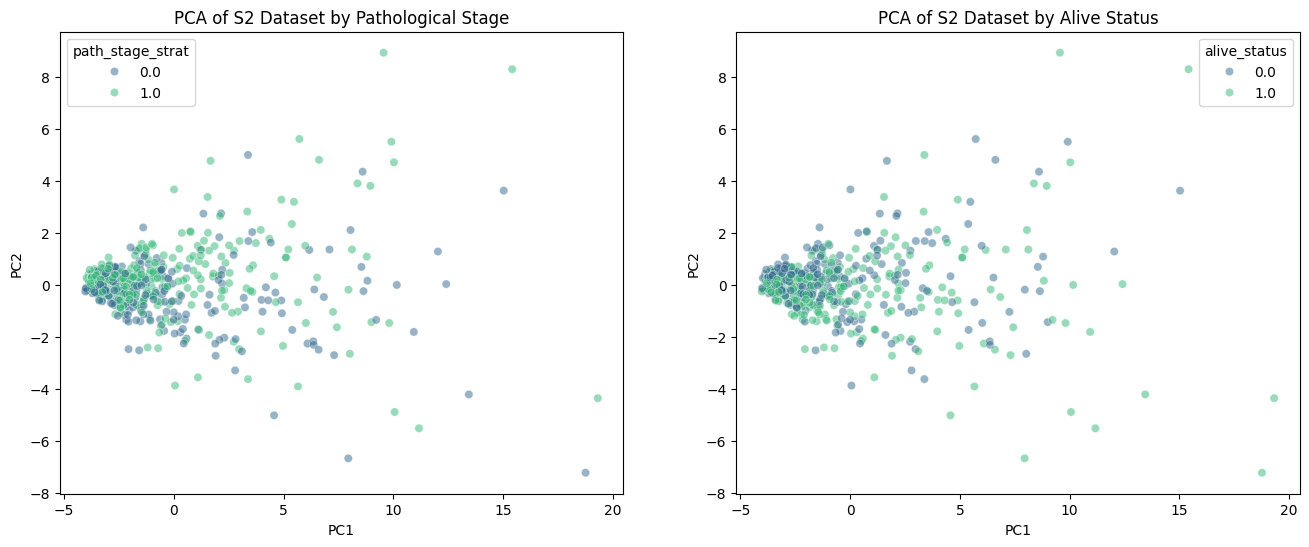

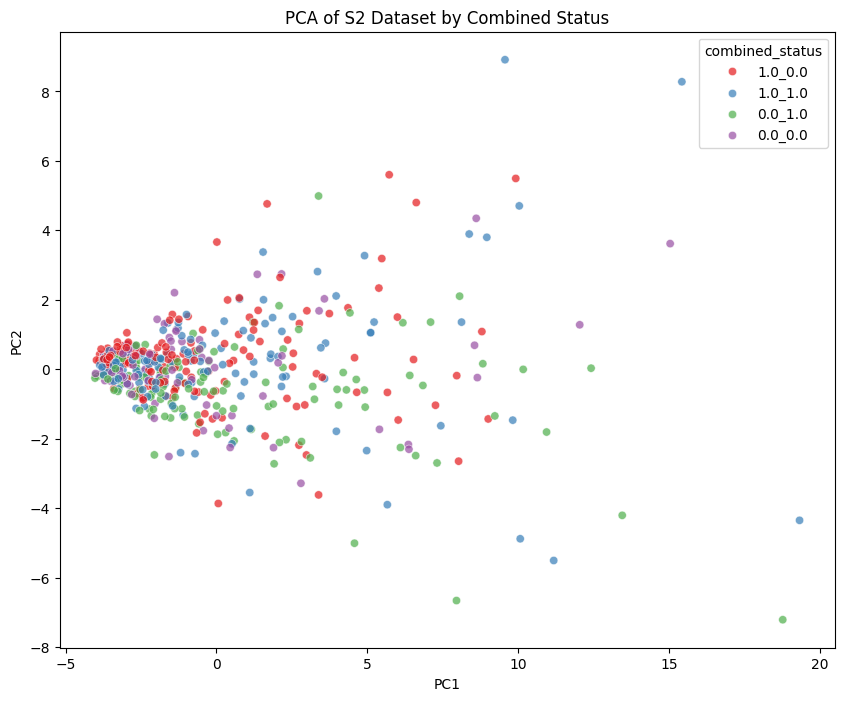

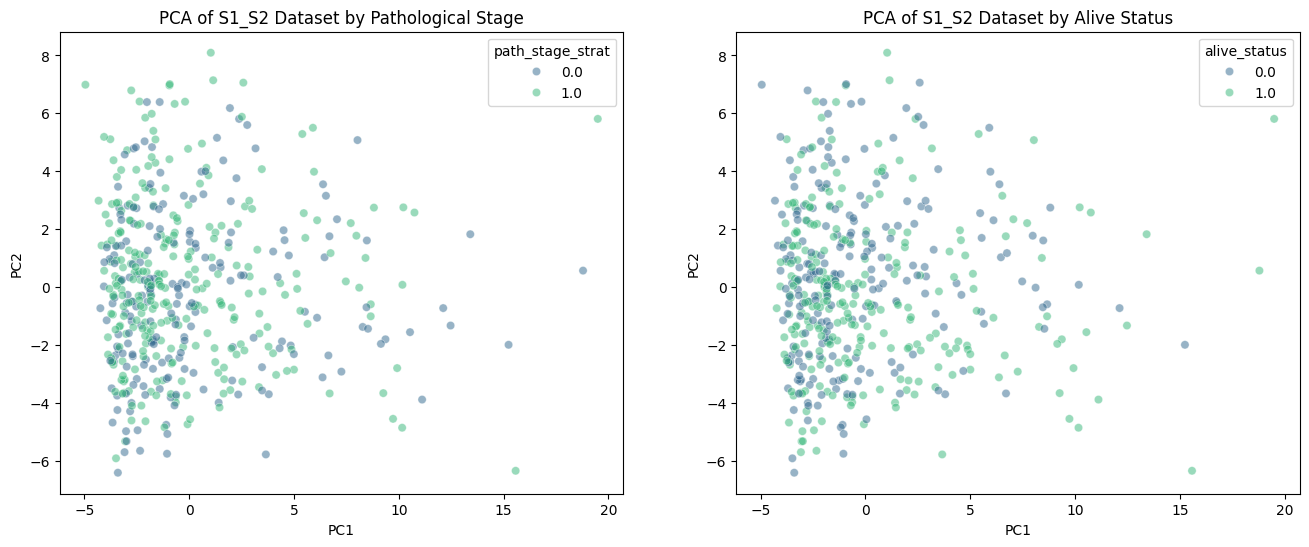

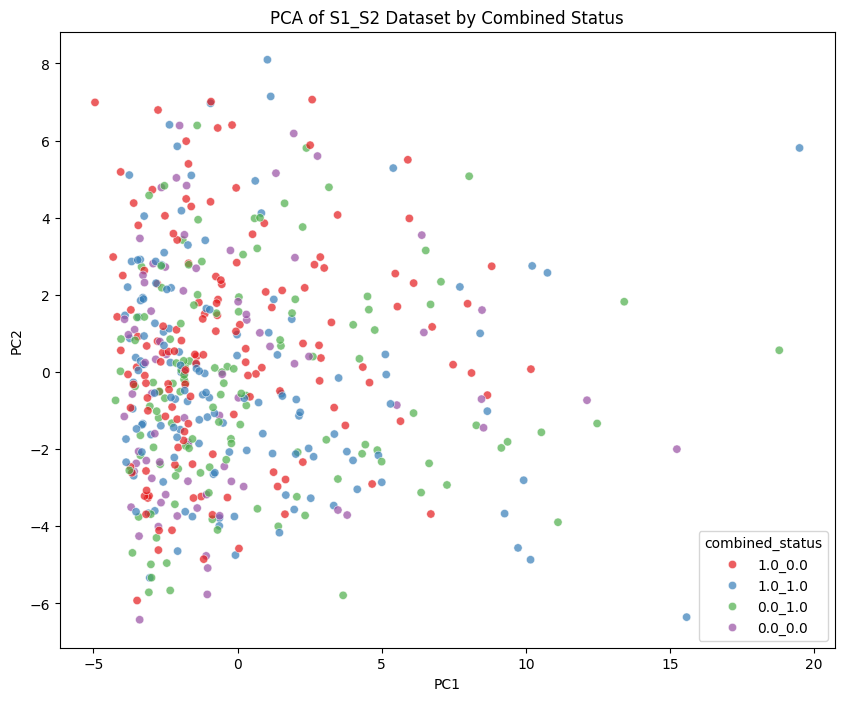

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

clinical_df = pd.read_csv('clinical.tsv', sep='\t')
clinical_df['path_stage_strat'] = clinical_df['ajcc_pathologic_stage'].replace("'--", np.NaN).map({'Stage I': 0, 'Stage II': 0, 'Stage III': 0, 'Stage IVA': 1, 'Stage IVB': 1, 'Stage IVC': 1})
clinical_df['alive_status'] = np.where(clinical_df['days_to_death'].isna() | (clinical_df['days_to_death'] == "'--"), 1, 0)
clinical_df = clinical_df[['case_id', 'path_stage_strat', 'alive_status']]

file_to_case_df = pd.read_csv('file_to_case.tsv', sep='\t')
data_files = ['rnaseq_s1.tsv', 'rnaseq_s2.tsv', 'rnaseq_s1_s2.tsv']
data_frame_names = ['S1', 'S2', 'S1_S2']

for data_file, name in zip(data_files, data_frame_names):
    df = pd.read_csv(data_file, sep='\t')
    df = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df = pd.merge(df, clinical_df, on='case_id', how='left').dropna()
    
    df['combined_status'] = df['path_stage_strat'].astype(str) + "_" + df['alive_status'].astype(str)
    
    X = StandardScaler().fit_transform(df.select_dtypes(include=[np.number]))
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
    finalDf = pd.concat([principalDf, df[['path_stage_strat', 'alive_status', 'combined_status']].reset_index(drop=True)], axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    sns.scatterplot(ax=axs[0], x='PC1', y='PC2', hue='path_stage_strat', data=finalDf, palette='viridis', alpha=0.5)
    axs[0].set_title(f'PCA of {name} Dataset by Pathological Stage')
    
    sns.scatterplot(ax=axs[1], x='PC1', y='PC2', hue='alive_status', data=finalDf, palette='viridis', alpha=0.5)
    axs[1].set_title(f'PCA of {name} Dataset by Alive Status')
    
    plt.show()
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='combined_status', data=finalDf, palette='Set1', alpha=0.7)
    plt.title(f'PCA of {name} Dataset by Combined Status')
    plt.show()


In [49]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

data_files = ['rnaseq_s1.tsv', 'rnaseq_s2.tsv', 'rnaseq_s1_s2.tsv']
data_frame_names = ['S1', 'S2', 'S1_S2']
label_encoder = LabelEncoder()  

for file_name, dataset_name in zip(data_files, data_frame_names):
    print(f"Results for dataset {dataset_name}:")
    df = pd.read_csv(file_name, sep='\t')
    df = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df = pd.merge(df, clinical_df, on='case_id', how='left').dropna()

    X = df.select_dtypes(include=[np.number]).drop(columns=['path_stage_strat', 'alive_status'])
    df['combined_status'] = df['path_stage_strat'].astype(str) + '_' + df['alive_status'].astype(str)
    y = label_encoder.fit_transform(df['combined_status'])  

    accuracies = {label: [] for label in np.unique(y)}
    total_accuracy = []

    for _ in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
        classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
        classifier.fit(X_train, y_train)

        preds = classifier.predict(X_test)
        total_accuracy.append(accuracy_score(y_test, preds))
        for label in accuracies:
            selected = (y_test == label)
            if selected.any():
                accuracies[label].append(accuracy_score(y_test[selected], preds[selected]))

    for label, acc_list in accuracies.items():
        decoded_label = label_encoder.inverse_transform([label])[0]
        mean_accuracy = np.mean(acc_list)
        print(f"  Combined status {decoded_label}: Average accuracy = {mean_accuracy:.4f}")
    print(f"  Total average accuracy: {np.mean(total_accuracy):.4f}\n")

Results for dataset S1:
  Combined status 0.0_0.0: Average accuracy = 0.1087
  Combined status 0.0_1.0: Average accuracy = 0.2727
  Combined status 1.0_0.0: Average accuracy = 0.3810
  Combined status 1.0_1.0: Average accuracy = 0.3500
  Total average accuracy: 0.3017

Results for dataset S2:
  Combined status 0.0_0.0: Average accuracy = 0.1647
  Combined status 0.0_1.0: Average accuracy = 0.3377
  Combined status 1.0_0.0: Average accuracy = 0.4028
  Combined status 1.0_1.0: Average accuracy = 0.3421
  Total average accuracy: 0.3317

Results for dataset S1_S2:
  Combined status 0.0_0.0: Average accuracy = 0.1407
  Combined status 0.0_1.0: Average accuracy = 0.3538
  Combined status 1.0_0.0: Average accuracy = 0.4369
  Combined status 1.0_1.0: Average accuracy = 0.3900
  Total average accuracy: 0.3561



In [60]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import xgboost as xgb
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.metrics import accuracy_score

data_files = ['rnaseq_s1.tsv', 'rnaseq_s2.tsv', 'rnaseq_s1_s2.tsv']
data_frame_names = ['S1', 'S2', 'S1_S2']
label_encoder = LabelEncoder() 

for file_name, dataset_name in zip(data_files, data_frame_names):
    print(f"Results for dataset {dataset_name}:")
    df = pd.read_csv(file_name, sep='\t')
    df = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df = pd.merge(df, clinical_df, on='case_id', how='left').dropna()

    X = MinMaxScaler().fit_transform(df.select_dtypes(include=[np.number]).drop(columns=['path_stage_strat', 'alive_status']))
    df['combined_status'] = df['path_stage_strat'].astype(str) + '_' + df['alive_status'].astype(str)
    y = label_encoder.fit_transform(df['combined_status'])

    input_img = Input(shape=(X.shape[1],))
    encoded = Dense(20, activation='relu')(input_img)
    encoded = Dense(10, activation='relu')(encoded)
    encoded = Dense(5, activation='relu')(encoded)
    decoded = Dense(10, activation='relu')(encoded)
    decoded = Dense(20, activation='relu')(decoded)
    decoded = Dense(X.shape[1], activation='sigmoid')(decoded)

    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)

    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X, X, epochs=50, batch_size=256, validation_split=0.2, verbose=0)

    X_encoded = encoder.predict(X)

    accuracies = {label: [] for label in np.unique(y)}
    total_accuracy = []

    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y)
        classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
        classifier.fit(X_train, y_train)

        preds = classifier.predict(X_test)
        total_accuracy.append(accuracy_score(y_test, preds)) 
        for label in accuracies:
            selected = (y_test == label)
            accuracies[label].append(accuracy_score(y_test[selected], preds[selected]) if selected.any() else np.nan)

    for label, acc_list in accuracies.items():
        decoded_label = label_encoder.inverse_transform([label])[0]
        mean_accuracy = np.nanmean(acc_list)
        print(f"  Combined status {decoded_label}: Average accuracy = {mean_accuracy:.4f}")
    print(f"  Total average accuracy: {np.mean(total_accuracy):.4f}\n") 


Results for dataset S1:
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
  Combined status 0.0_0.0: Average accuracy = 0.1560
  Combined status 0.0_1.0: Average accuracy = 0.3096
  Combined status 1.0_0.0: Average accuracy = 0.3017
  Combined status 1.0_1.0: Average accuracy = 0.3239
  Total average accuracy: 0.2879

Results for dataset S2:
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
  Combined status 0.0_0.0: Average accuracy = 0.1267
  Combined status 0.0_1.0: Average accuracy = 0.2292
  Combined status 1.0_0.0: Average accuracy = 0.2890
  Combined status 1.0_1.0: Average accuracy = 0.3321
  Total average accuracy: 0.2606

Results for dataset S1_S2:
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
  Combined status 0.0_0.0: Average accuracy = 0.1407
  Combined status 0.0_1.0: Average accuracy = 0.2123
  Combined status 1.0_0.0: Average accuracy = 0.2886
  Combined status 1.0_1.0: Average accuracy = 0.2864
  Total average accuracy: 0.2451



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


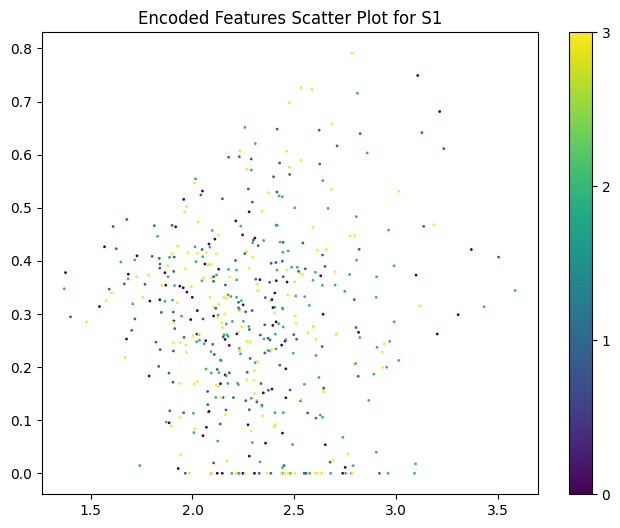

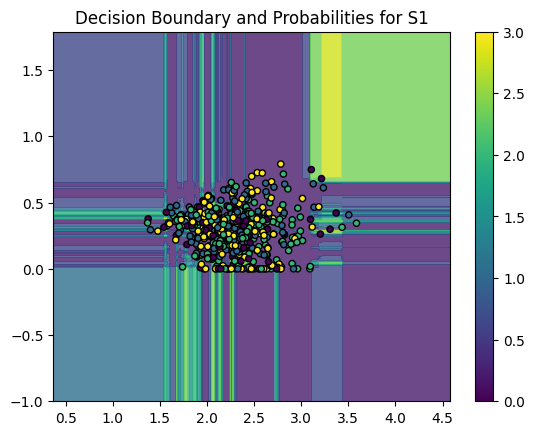

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


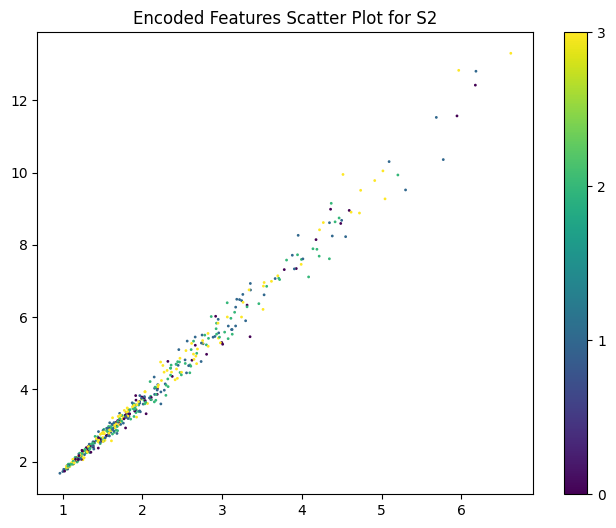

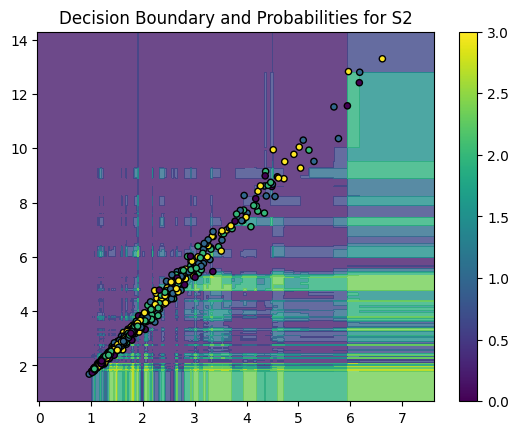

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


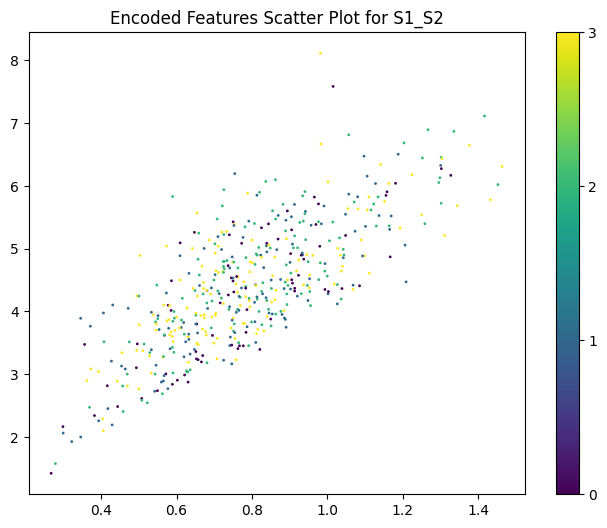

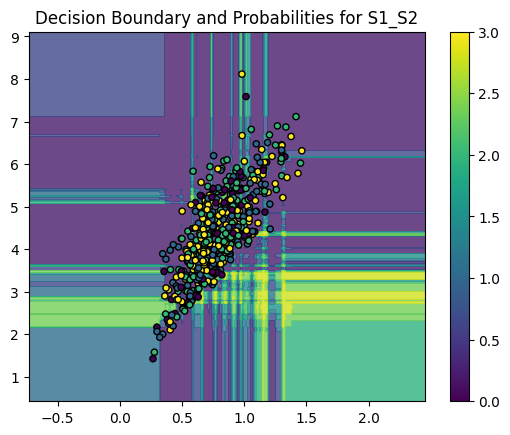

In [77]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from keras.models import Model
from keras.layers import Input, Dense
import matplotlib.pyplot as plt

data_files = ['rnaseq_s1.tsv', 'rnaseq_s2.tsv', 'rnaseq_s1_s2.tsv']
data_frame_names = ['S1', 'S2', 'S1_S2']

for file_name, dataset_name in zip(data_files, data_frame_names):
    df = pd.read_csv(file_name, sep='\t')
    df = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df = pd.merge(df, clinical_df, on='case_id', how='left').dropna()

    df['combined_status'] = df['path_stage_strat'].astype(str) + '_' + df['alive_status'].astype(str)
    y = LabelEncoder().fit_transform(df['combined_status'])

    X = MinMaxScaler().fit_transform(df.select_dtypes(include=[np.number]).drop(columns=['path_stage_strat', 'alive_status']))

    input_img = Input(shape=(X.shape[1],))
    encoded = Dense(64, activation='relu')(input_img)
    encoded = Dense(32, activation='relu')(encoded)
    encoded = Dense(2, activation='relu')(encoded)
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(decoded)
    decoded = Dense(X.shape[1], activation='sigmoid')(decoded)

    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)

    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X, X, epochs=50, batch_size=256, validation_split=0.2, verbose=0)

    X_encoded = encoder.predict(X)

    classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    classifier.fit(X_encoded, y)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_encoded[:, 0], X_encoded[:, 1], c=y, cmap='viridis', s=1, alpha=1)
    plt.title(f"Encoded Features Scatter Plot for {dataset_name}")
    plt.colorbar(scatter, ticks=range(len(np.unique(y))))
    plt.show()

    x_min, x_max = X_encoded[:, 0].min() - 1, X_encoded[:, 0].max() + 1
    y_min, y_max = X_encoded[:, 1].min() - 1, X_encoded[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])

    Z = Z[:, 0].reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='viridis')
    plt.scatter(X_encoded[:, 0], X_encoded[:, 1], c=y, cmap='viridis', s=20, edgecolor='k')
    plt.title(f"Decision Boundary and Probabilities for {dataset_name}")
    plt.colorbar()
    plt.show()